# NPS-Barnacles
## Author: Arnav Singh

## Abstract

This notebook documents the process of developing a system to help scientists count barnacles in images more efficiently. The approach involves data preprocessing, exploration with a basic model, and an attempt to implement a Vision Transformer (ViT) for improved accuracy.

---

## Table of Contents

1. [Introduction](#introduction)
2. [Methodology](#methodology)
3. [Enviroment Setup](#enviroment-setup)
4. [Data Loading and Preprocessing](#data-loading-and-preprocessing)
5. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
6. [Model Configuration](#model-configuration)
7. [Model Training](#model-training)
8. [Counting Barnacles and Evaluation](#counting-barnacles-and-evalution)
9. [SOTA Model](#sota-model)
10. [Conclusion & Results](#conlusion-and-results)
11. [Learning and Next Steps](#learning-and-next-steps)

---

## Introduction

The goal is to automate the counting of barnacles within a fixed-size frame in images. This involves preprocessing the images, exploring basic models, and implementing a more advanced model like ViT to achieve higher accuracy.

## Methodology

First we are going to create

## Enviroment Setup

In [146]:
# Importing the necessasry libraries, make sure they are correctly installed if running the code on your local machine
import os
import pandas as pd
import random
import shutil
from pathlib import Path
from typing import Tuple, List
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import fcn_resnet50
from tqdm import tqdm

# Local python script
from barnacle_py.utils import (
    detect_green_frame,
    create_image_grid,
    detect_barnacles,
    BarnacleDataset,
    get_default_transforms
)
import barnacle_py.utils as utils  # for reloading
import importlib

# Reloads if I made changes to utils
importlib.reload(utils)

# Configuration settings for notebook
RANDOM_SEED = 42
VAL_RATIO = 0.2
IMG_SIZE = (256, 256)
BATCH_SIZE = 4
NUM_EPOCHS = 10
DATA_PATHS = {
    'raw': Path("Barnacles"),
    'processed': Path("processed"),
    'train': Path("train"),
    'val': Path("val"),
    'test': Path("test")
}

# For reproducibility
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Data Loading and Preprocessing
First we load the images, and the masks for the data, and then prep them for training. The following code below can be adapted to better suite preprocessing pipelines for larger scale applications of counting barancles. Included some edge case checking.

libpng warning: iCCP: known incorrect sRGB profile



=== Processing Verification ===


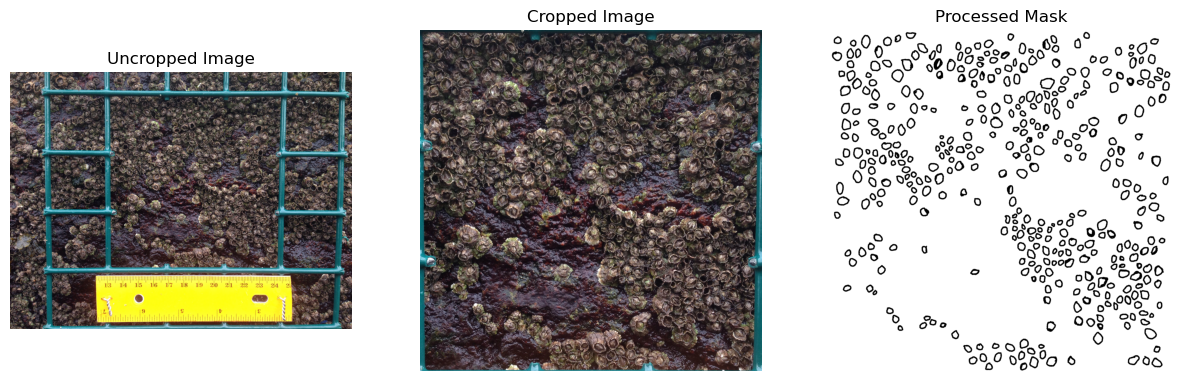

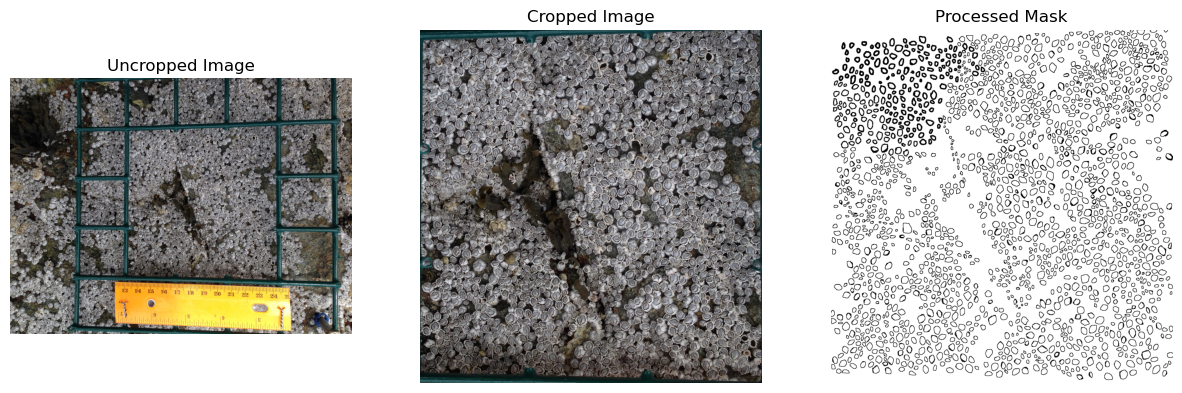

In [78]:
def process_image_and_mask(image_name, mask_name):
    """
    Process a single image and its corresponding mask.
    """
    # Process image
    image_path = DATA_PATHS['raw'] / image_name
    image, (x, y, w, h) = detect_green_frame(str(image_path))
    output_image_path = DATA_PATHS['processed'] / image_name
    cv2.imwrite(str(output_image_path), image[y:y+h, x:x+w])

    # Process mask (if provided)
    if mask_name:
        mask_path = DATA_PATHS['raw'] / mask_name
        mask = cv2.imread(str(mask_path))
        output_mask_path = DATA_PATHS['processed'] / mask_name
        cv2.imwrite(str(output_mask_path), mask[y:y+h, x:x+w])

def preprocess_images():
    """Image and mask preprocessing pipeline"""
    # Ensure output directory exists
    DATA_PATHS['processed'].mkdir(exist_ok=True)

    # Define image and mask pairs
    image_mask_pairs = [
        ("img1.png", "mask1.png"),
        ("img2.png", "mask2.png"),
        ("unseen_img1.png", None)  # No mask for this image
    ]

    # Process each pair
    for image_name, mask_name in image_mask_pairs:
        process_image_and_mask(image_name, mask_name)

# Execute the preprocessing
preprocess_images()

def verify_processing():
    """Comprehensive output verification with uncropped image comparison."""
    print("\n=== Processing Verification ===")

    # Check directory structure
    required_dirs = [DATA_PATHS['processed'], DATA_PATHS['raw']]
    for d in required_dirs:
        if not d.exists():
            print(f"Missing directory: {d}")
            return

    # Verify image-mask pairs
    for img_path in DATA_PATHS['processed'].glob("img*.png"):
        raw_image_path = DATA_PATHS['raw'] / img_path.name
        mask_path = DATA_PATHS['processed'] / f"mask{img_path.stem[3:]}.png"

        if not raw_image_path.exists():
            print(f"Missing raw image: {raw_image_path.name}")
            continue

        if not mask_path.exists():
            print(f"Missing mask: {mask_path.name}")
            continue

        # Load and validate files
        processed_img = cv2.imread(str(img_path))
        raw_img = cv2.imread(str(raw_image_path))
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if processed_img is None:
            print(f"Corrupted processed image: {img_path.name}")
            continue

        if raw_img is None:
            print(f"Corrupted raw image: {raw_image_path.name}")
            continue

        if mask is None:
            print(f"Corrupted mask: {mask_path.name}")
            continue
        elif mask.sum() == 0:
            print(f"Empty mask: {mask_path.name}")
        else:
            # Display uncropped and cropped images with mask
            plt.figure(figsize=(15, 5))
            plt.subplot(131)
            plt.imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))
            plt.title("Uncropped Image")
            plt.axis('off')

            plt.subplot(132)
            plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
            plt.title("Cropped Image")
            plt.axis('off')

            plt.subplot(133)
            plt.imshow(mask, cmap='gray')
            plt.title("Processed Mask")
            plt.axis('off')

            plt.show()

# Call the verification function
verify_processing()

Above, we see the data preprocessing pipeline in action: from the raw uncropped image, to the cropped iamge with hte processed mask. Here we take the data we preprocessed using our local util python script, and divide it into train, validation, and testing sets. We also implement the use of rotations to increase the size of the dataset, as if the model is seeing a new image. However, this approach could introduce some bias, especially with repeated images of barnacles.

In [117]:
def rotate_image(image, angle):
    """Rotate an image by a specified angle."""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, matrix, (w, h))

def create_training_segments():
    """Generate image segments for model training with clean setup and augmentations."""
    # Clear existing directories
    for split in ['train', 'val', 'test']:
        split_dir = DATA_PATHS[split]
        
        # Remove entire directory tree if exists
        if split_dir.exists():
            shutil.rmtree(split_dir)
            print(f"Cleared existing {split} directory")
            
        # Recreate directory structure
        (split_dir / 'data').mkdir(parents=True, exist_ok=True)
        (split_dir / 'mask').mkdir(exist_ok=True)

    # Process images into segments
    for img_path in DATA_PATHS['processed'].glob("*.png"):
        image = cv2.imread(str(img_path))
        segments = create_image_grid(image, (12, 12))  # Grid size
        
        split_type = 'test' if 'unseen' in img_path.name else 'train'
        dir_type = 'data' if 'img' in img_path.name else 'mask'

        for i, segment in enumerate(segments):
            output_dir = DATA_PATHS[split_type] / dir_type
            base_name = f"{img_path.stem}_seg{i}"

            # Save original segment
            cv2.imwrite(str(output_dir / f"{base_name}.png"), segment)

            # Generate rotated versions
            for angle in [90, 180, 270]:
                rotated = rotate_image(segment, angle)
                cv2.imwrite(str(output_dir / f"{base_name}_rot{angle}.png"), rotated)

    # Create validation split
    image_files = sorted(os.listdir(DATA_PATHS['train'] / 'data'))
    val_ratio = 0.25  # 25% validation split
    val_indices = np.random.choice(len(image_files), int(len(image_files) * val_ratio), replace=False)

    for idx in val_indices:
        img_file = image_files[idx]
        mask_file = img_file.replace("img", "mask")
        
        # Path objects for clarity
        img_src = DATA_PATHS['train'] / 'data' / img_file
        mask_src = DATA_PATHS['train'] / 'mask' / mask_file
        img_dst = DATA_PATHS['val'] / 'data' / img_file
        mask_dst = DATA_PATHS['val'] / 'mask' / mask_file

        # Safe move with existence check
        if img_src.exists() and mask_src.exists():
            shutil.move(str(img_src), str(img_dst))
            shutil.move(str(mask_src), str(mask_dst))
        else:
            print(f"Missing pair: {img_file} | {mask_file}")

# Call the function to create training segments with rotations
create_training_segments()

Cleared existing train directory
Cleared existing val directory
Cleared existing test directory


## Exploratory Data Analysis

Here we do some checks for the training and validation data we have access too, exploring the data to perhaps uncover truths before even modeling.

### 1. Dataset Summary Statistics

In [118]:
def analyze_dataset(directory: Path) -> dict:
    """Calculating the key dataset statistics"""
    stats = {
        'num_images': 0,
        'resolutions': [],
        'aspect_ratios': [],
        'mean_intensity': [],
        'mask_coverage': []
    }
    
    for img_path in directory.glob('**/*.png'):
        image = cv2.imread(str(img_path))
        stats['num_images'] += 1
        stats['resolutions'].append(image.shape[:2])
        stats['aspect_ratios'].append(image.shape[1]/image.shape[0])
        stats['mean_intensity'].append(image.mean())
        
        if 'mask' in str(img_path):
            mask = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            coverage = mask.sum() / (mask.size * 255)
            stats['mask_coverage'].append(coverage)
            
    return stats

# Calculate stats for each split
train_stats = analyze_dataset(DATA_PATHS['train'])
val_stats = analyze_dataset(DATA_PATHS['val'])
test_stats = analyze_dataset(DATA_PATHS['test'])

# summary table
stats_df = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Images': [train_stats['num_images'], val_stats['num_images'], test_stats['num_images']],
    'Avg Resolution': [
        np.mean(train_stats['resolutions'], axis=0).astype(int),
        np.mean(val_stats['resolutions'], axis=0).astype(int),
        np.mean(test_stats['resolutions'], axis=0).astype(int)
    ],
    'Barnacle Coverage (%)': [
        np.mean(train_stats['mask_coverage'])*100,
        np.mean(val_stats['mask_coverage'])*100,
        np.mean(test_stats['mask_coverage'])*100
    ]
})

display(stats_df.style.format({'Barnacle Coverage (%)': '{:.1f}%'}))

,Split,Images,Avg Resolution,Barnacle Coverage (%)
0,Train,1728,[129 127],89.8%
1,Validation,576,[129 127],89.5%
2,Test,576,[132 133],nan%


Notice how we were able to increase our dataset from two images with their respective masks to over ~2800 samples. This can be altered in the earlier steps of the notebook and is open to experimenation. For example, the grid size used to cut up the cropped image can be changed to whatever liking is pleased, such as a 5x5 grid, or even a 20x20 grid. Benefit is that there is substantial barancle coveragae, so increasing the grid size should illicit higher identification of seperate barnacles. However, tradeoff is that the resolution of the frame descreases, leading to less confident results. 

### 2. Visual Feature Analysis

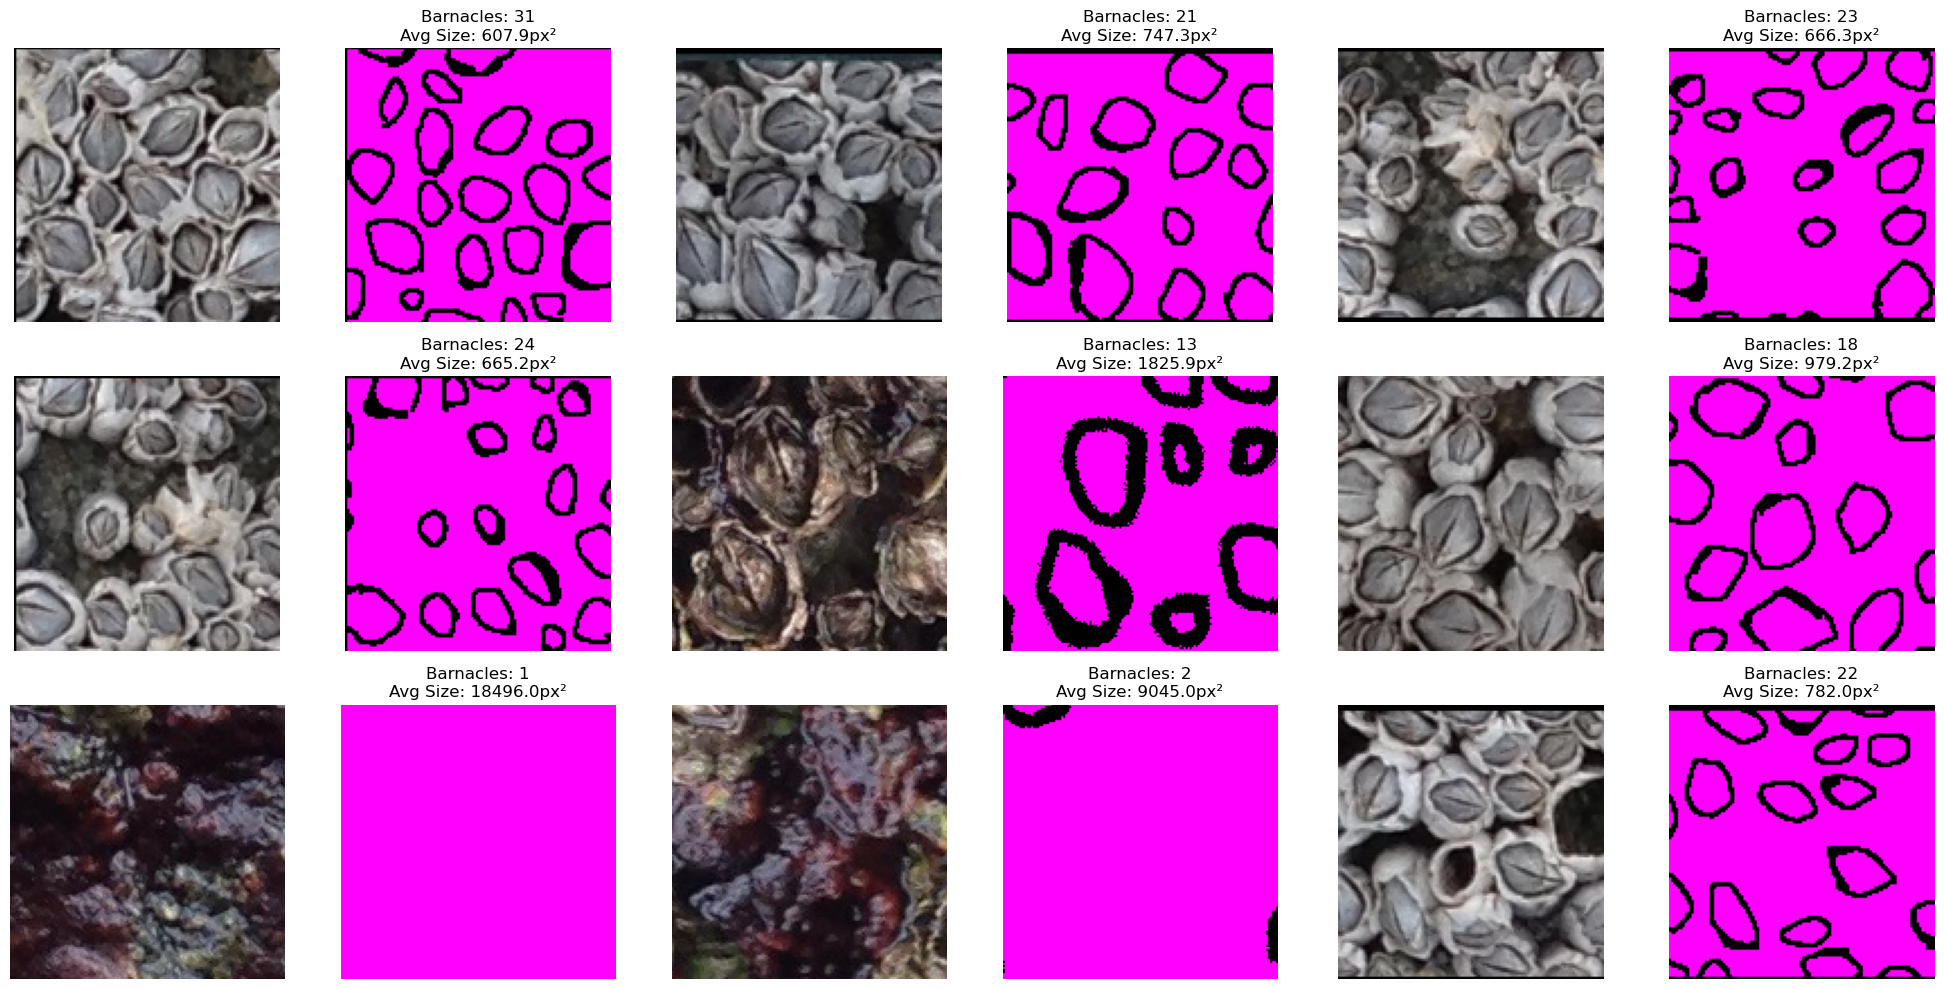

In [137]:
def plot_sample_grid(n_rows=3, n_cols=3):
    """Visualize image/mask pairs with barnacle statistics"""
    fig, axs = plt.subplots(n_rows, n_cols*2, figsize=(20, 10))
    
    # paired image/mask paths
    sample_pairs = []
    image_files = list((DATA_PATHS['train']/'data').glob('img*.png'))
    
    for img_path in random.sample(image_files, n_rows*n_cols):
        mask_file = img_path.name.replace("img", "mask")
        mask_path = DATA_PATHS['train']/'mask'/mask_file
        
        if mask_path.exists():
            sample_pairs.append((img_path, mask_path))
        else:
            print(f"Missing mask: {mask_path}")
    
    for i, (img_path, mask_path) in enumerate(sample_pairs[:n_rows*n_cols]):
        try:
            # Load image
            image = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
            if image is None:
                raise ValueError(f"Failed to load image: {img_path}")
            
            # Load mask
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise ValueError(f"Failed to load mask: {mask_path}")

            # --- Contour Detection ---
            # Preprocess mask
            _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1,1))
            processed_mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=10)
            
            # Find contours
            contours, _ = cv2.findContours(processed_mask, 
                                         cv2.RETR_LIST,
                                         cv2.CHAIN_APPROX_SIMPLE)
            
            # Filter contours
            height, width = mask.shape
            min_area = max(5, (height * width) / 500)  # Had a hard time trying to find the right value
            filtered_contours = [c for c in contours if cv2.contourArea(c) > min_area]
            
            # Calculate statistics
            areas = [cv2.contourArea(c) for c in filtered_contours]
            avg_size = np.mean(areas) if filtered_contours else 0

            # Plot image
            ax = axs[i//n_cols, (i%n_cols)*2]
            ax.imshow(image)
            ax.axis('off')
            
            # Plot mask with processed version
            ax = axs[i//n_cols, (i%n_cols)*2+1]
            mask_overlay = cv2.cvtColor(processed_mask, cv2.COLOR_GRAY2RGB)
            mask_overlay[..., 1] = 0  # Remove green channel
            ax.imshow(mask_overlay)
            
            ax.set_title(f"Barnacles: {len(filtered_contours)}\nAvg Size: {avg_size:.1f}px²")
            ax.axis('off')
            
        except Exception as e:
            print(f"Error processing {img_path.name}: {str(e)}")
            axs[i//n_cols, (i%n_cols)*2].axis('off')
            axs[i//n_cols, (i%n_cols)*2+1].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_grid()

Looking at the sample grid of the subsection of barancle vs the mask, we see some discrepancies with the counting, likely due to the contour mapping. Some estimates of the number of barnacles are over and some are under. This suggests defining the correct alogrithm to identify the contours of the barnacles is particularly tricky, requiring more optimization, or expertise. 

### 3. Intensity Distribution Analysis
In trying to come up with ideas for exploratory analysis, I got this suggestion from ChatGPT, helps to identify the makeup of the images at its core.

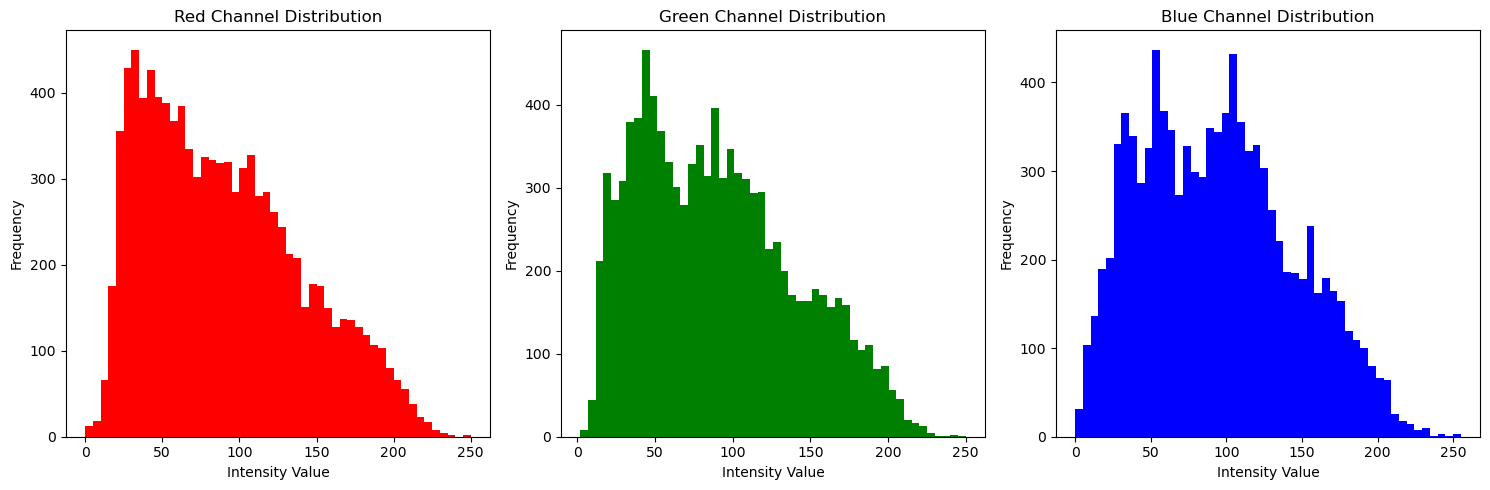

In [139]:
def plot_channel_distributions():
    """Plot RGB channel distributions for biological substrate"""
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    
    # Sample 100 valid image patches
    barnacle_patches = []
    attempts = 0
    max_attempts = 500  # Prevent infinite loop
    
    while len(barnacle_patches) < 100 and attempts < max_attempts:
        attempts += 1
        try:
            # Get random image-mask pair
            img_path = random.choice(list((DATA_PATHS['train']/'data').glob('*.png')))
            mask_path = DATA_PATHS['train']/'mask'/img_path.name.replace("img", "mask")
            
            # Load data with validation
            image = cv2.imread(str(img_path))
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            
            if image is None or mask is None:
                continue
                
            if mask.sum() == 0:  # Skip empty masks
                continue
                
            # Get random barnacle region
            nonzero = np.argwhere(mask > 0)
            if len(nonzero) == 0:
                continue
                
            y, x = nonzero[random.randint(0, len(nonzero)-1)]
            
            # Ensure valid patch dimensions
            if y-5 < 0 or y+5 > image.shape[0] or x-5 < 0 or x+5 > image.shape[1]:
                continue
                
            patch = image[y-5:y+5, x-5:x+5]
            if patch.shape[:2] == (10, 10):  # Verify patch size
                barnacle_patches.append(patch)
                
        except Exception as e:
            print(f"Error processing {img_path.name}: {str(e)}")
            continue
    
    if not barnacle_patches:
        print("No valid barnacle patches found")
        return
    
    # Calculate channel statistics
    patches = np.stack(barnacle_patches)
    channels = ['Red', 'Green', 'Blue']
    
    for i in range(3):
        ax[i].hist(patches[...,i].flatten(), bins=50, color=channels[i].lower())
        ax[i].set_title(f"{channels[i]} Channel Distribution")
        ax[i].set_xlabel('Intensity Value')
        ax[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

plot_channel_distributions()

The histograms reveal some key insights: the Red Channel shows a skewed narrow distribution with primary intensities between 40-100, indicating limited bright red components and darker barnacle appearances in the red spectrum. The Green Channel exhibits a more broader distribution with a double peak (50 and 100 intensity), suggesting moderate brightness and potential vegetation or algae presence near barnacles. The Blue Channel follows suit, but has the most skewed right distribution with dominant high-intensity values (~150), reflecting water reflections, shadow effects, and possible mineral content in barnacle shells. From a technical perspective, preprocessing adjustments are recommended, such as boosting red channel contrast, normalizing the green channel, and maintaining natural blue channel variation. Model training considerations include color augmentation, channel weighting, and loss function adjustments to account for intensity variations and color dominance. Action items include verifying data quality, implementing augmentation strategies like blue channel normalization and red channel contrast enhancement, and possible refining model architecture with blue-channel-focused layers and attention mechanisms. These observations are definitely up to discussion.

### 4. Barnacle Morphology Analysis
In coming up with ideas, this was also suggested by AI, and helps to understand the shapesof barnacles. Perhaps NPS/biologists can use this to also identify the health or type of barnacles too.

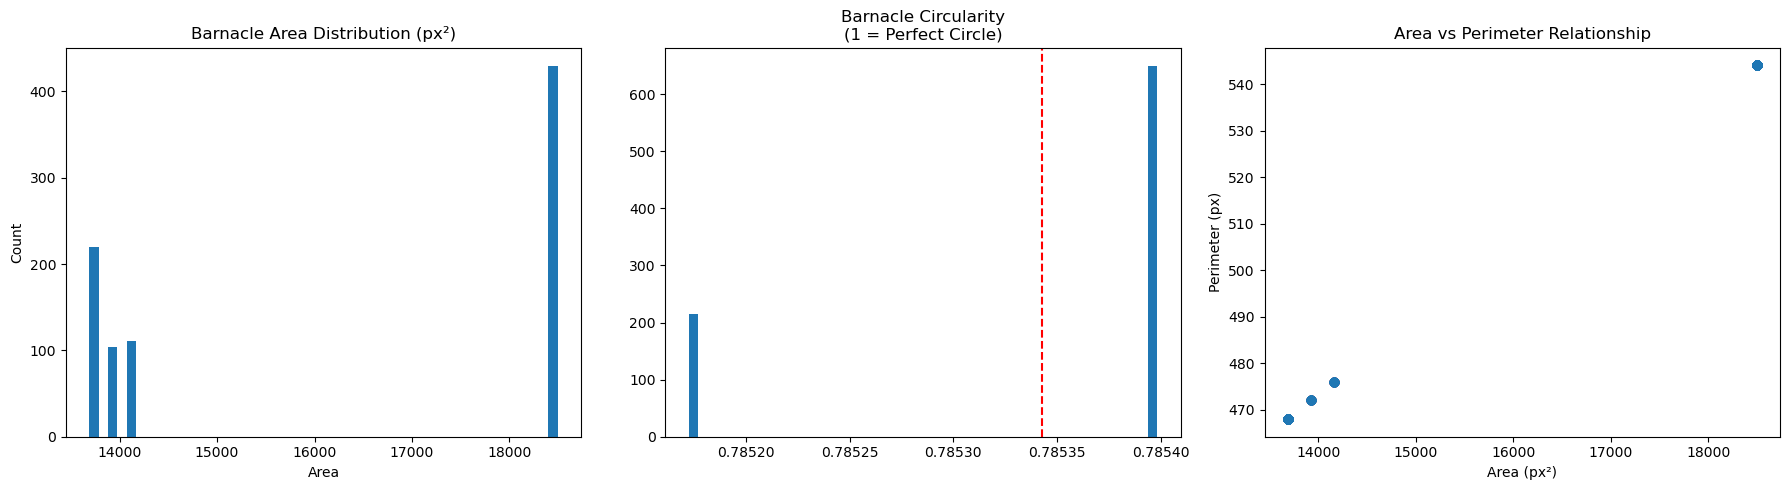

In [141]:
def analyze_barnacle_shapes():
    """Quantify barnacle shape characteristics"""
    all_areas = []
    all_perimeters = []
    circularities = []
    
    for mask_path in (DATA_PATHS['train']/'mask').glob('*.png'):
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for c in contours:
            area = cv2.contourArea(c)
            perimeter = cv2.arcLength(c, True)
            if perimeter > 0:
                circularity = 4*np.pi*area / (perimeter**2)
                circularities.append(circularity)
                all_areas.append(area)
                all_perimeters.append(perimeter)
    
    # Create summary plots
    fig, axs = plt.subplots(1, 3, figsize=(18,5))
    
    # Area distribution
    axs[0].hist(all_areas, bins=50)
    axs[0].set_title('Barnacle Area Distribution (px²)')
    axs[0].set_xlabel('Area')
    axs[0].set_ylabel('Count')
    
    # Circularity distribution
    axs[1].hist(circularities, bins=50)
    axs[1].set_title('Barnacle Circularity\n(1 = Perfect Circle)')
    axs[1].axvline(np.mean(circularities), color='r', linestyle='--')
    
    # Area vs Perimeter
    axs[2].scatter(all_areas, all_perimeters, alpha=0.3)
    axs[2].set_title('Area vs Perimeter Relationship')
    axs[2].set_xlabel('Area (px²)')
    axs[2].set_ylabel('Perimeter (px)')
    
    plt.tight_layout()
    plt.show()

analyze_barnacle_shapes()

Bimodal data suggests that the clustering of the barnacles is likely due to there only being 2 images supplied. The count of barnacles spans from 100 to 400, indicating substantial variability in population density, and types of barnacles. Circularity measurements, where a value of 1 represents a perfect circle, suggest that barnacles exhibit near-circular shapes, with values consistently close to 0.785. The average circus distance, measured in USB units, shows a range from 400 to 540, highlighting variability in spatial distribution patterns. The area measurements, ranging between 14000 and 18000 px², further emphasize the diversity in barnacle sizes, likely due to the clustering of data due to two images. In coming up with more ideas, LLM's suggested the relationship between area and perimeter, so why not, helps to understand the spatial organization and morphological characteristics of barnacle populations, which can inform ecological studies and habitat assessments.

## Modeling Configuration
Testing a basic Convultion Neural Network, based on the ResNet-50 backbone, which is fine-tuned for a binary semantic segmentation task. Hopefully it should work well with Barnacles.

In [148]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

train_dataset = BarnacleDataset(
    image_dir='train/data',
    mask_dir='train/mask',
    transform=transform
)

val_dataset = BarnacleDataset(
    image_dir=DATA_PATHS['val']/'data',
    mask_dir=DATA_PATHS['val']/'mask',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model Training

/var/folders/gg/qxtxkv2501v1x8qx_r4vgk_m0000gn/T/ipykernel_17486/431711029.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/10:   0%|          | 0/216 [00:00<?, ?it/s]/var/folders/gg/qxtxkv2501v1x8qx_r4vgk_m0000gn/T/ipykernel_17486/431711029.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10: 100%|██████████| 216/216 [06:48<00:00,  1.89s/it]


New best model saved with val loss: 0.2846
Epoch 1
Train Loss: 0.6023 | Val Loss: 0.2846
LR: 1.00e-04


Epoch 2/10: 100%|██████████| 216/216 [06:54<00:00,  1.92s/it]


New best model saved with val loss: 0.2408
Epoch 2
Train Loss: 0.2682 | Val Loss: 0.2408
LR: 1.00e-04


Epoch 3/10: 100%|██████████| 216/216 [07:10<00:00,  1.99s/it]


New best model saved with val loss: 0.2367
Epoch 3
Train Loss: 0.2384 | Val Loss: 0.2367
LR: 1.00e-04


Epoch 4/10: 100%|██████████| 216/216 [21:48<00:00,  6.06s/it]   


New best model saved with val loss: 0.2314
Epoch 4
Train Loss: 0.2275 | Val Loss: 0.2314
LR: 1.00e-04


Epoch 5/10: 100%|██████████| 216/216 [07:19<00:00,  2.04s/it]


New best model saved with val loss: 0.2202
Epoch 5
Train Loss: 0.2175 | Val Loss: 0.2202
LR: 1.00e-04


Epoch 6/10: 100%|██████████| 216/216 [07:40<00:00,  2.13s/it]


Epoch 6
Train Loss: 0.2067 | Val Loss: 0.2230
LR: 1.00e-04


Epoch 7/10: 100%|██████████| 216/216 [07:04<00:00,  1.97s/it]


Epoch 7
Train Loss: 0.1983 | Val Loss: 0.2283
LR: 1.00e-04


Epoch 8/10: 100%|██████████| 216/216 [07:14<00:00,  2.01s/it]


Epoch 8
Train Loss: 0.1971 | Val Loss: 0.2240
LR: 1.00e-04


Epoch 9/10: 100%|██████████| 216/216 [07:20<00:00,  2.04s/it]


Epoch 9
Train Loss: 0.1955 | Val Loss: 0.2218
LR: 1.00e-05


Epoch 10/10: 100%|██████████| 216/216 [07:03<00:00,  1.96s/it]


New best model saved with val loss: 0.2146
Epoch 10
Train Loss: 0.1811 | Val Loss: 0.2146
LR: 1.00e-05


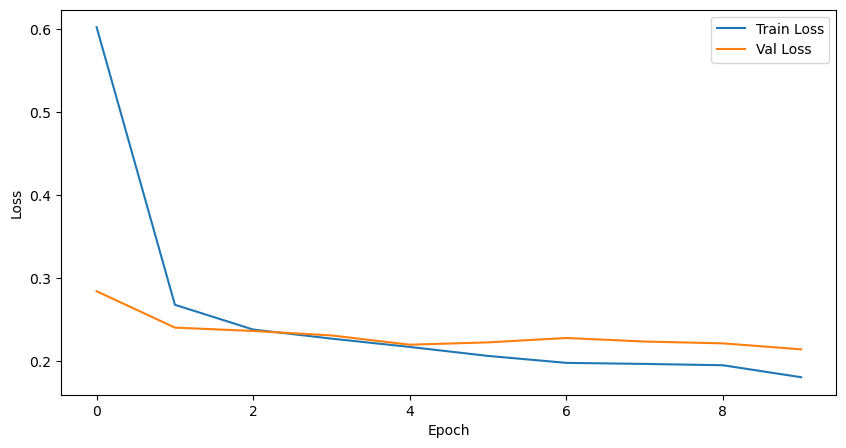

In [151]:
# Initialize model with proper weight initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fcn_resnet50(weights="DEFAULT")
model.classifier[4] = nn.Conv2d(512, 1, kernel_size=1)
model.classifier[4].apply(init_weights)  # Proper weight initialization
model = model.to(device)

# Mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, verbose=True
)

# Early stopping
best_val_loss = float('inf')
patience = 5
no_improvement = 0

# Metrics tracking
train_metrics = {'loss': []}
val_metrics = {'loss': []}

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    
    # Training phase with mixed precision
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(images)["out"]
            loss = criterion(outputs, masks.float())
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item() * images.size(0)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)["out"]
            val_loss += criterion(outputs, masks.float()).item() * images.size(0)

    # Calculate metrics
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
        }, "best_model.pth")
        print(f"New best model saved with val loss: {val_loss:.4f}")
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Track metrics
    train_metrics['loss'].append(train_loss)
    val_metrics['loss'].append(val_loss)
    
    # Logging
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_metrics['loss'], label='Train Loss')
plt.plot(val_metrics['loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Previous iterations of the code and results yielded a lower loss of below 0.15. However, compute time is quite long, so necessary optimizations must be used. Further analysis of this model would include a gridSearchCV esque hyperparameter tuning, and also testing the effect of different size grids and rotations of the dataset for barnacles. 

## Counting Barnacles and Evaluation
Now this is the ultimate test. The purpose of this whole project was to help out scientists in counting barnacles. As the previous section dictates, we can reasonable achieve a model with a low loss, so let's see where this leads us. 

In [209]:
def count_barnacles(binary_mask):
    """
    Count the barnacles and find contours in the binary mask.
    
    Parameters:
        binary_mask (numpy.ndarray): Binary mask (uint8) where barnacles are segmented.
    
    Returns:
        count (int): Number of barnacles detected.
        contours (list): List of contours for the detected barnacles.
    """
    
    # Threshold the mask (in case it's not binary)
    _, thresh = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
    
    # Filter contours based on area (optional)
    min_area = 15  # Set a minimum area threshold for valid barnacles
    filtered_contours = [c for c in contours if cv2.contourArea(c) > min_area]
    
    # Return the count and filtered contours
    return len(filtered_contours), filtered_contours

def visualize_prediction(model: nn.Module, test_dir: Path = DATA_PATHS['test']/'data'):
    """Visualize model predictions on test data"""
    model.eval()
    test_image = cv2.imread(str(random.choice(list(test_dir.glob("*.png")))))
    
    with torch.no_grad():
        proc_image = transform(test_image).unsqueeze(0).to(device)
        output = torch.sigmoid(model(proc_image)["out"]).cpu().squeeze().numpy()
    
    # Post-processing
    output = (output * 255).astype(np.uint8)
    count, contours = count_barnacles(output)
    
    # Visualization
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    
    ax[1].imshow(output, cmap="gray")
    ax[1].set_title("Model Prediction")
    
    contour_img = cv2.drawContours(
        cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB),
        contours,
        -1,
        (0, 255, 0),
        2
    )
    ax[2].imshow(contour_img)
    ax[2].set_title(f"Detected Barnacles: {count}")
    
    plt.tight_layout()
    plt.show()

# Load best model and visualize
# Load the full checkpoint
checkpoint = torch.load("best_model.pth", map_location=device)

# Extract only the model's weights
if "model_state_dict" in checkpoint:
    model.load_state_dict(checkpoint["model_state_dict"])
else:
    model.load_state_dict(checkpoint)  # Directly load if it's just the state_dict

print("Model weights loaded successfully!")
visualize_prediction(model)

/var/folders/gg/qxtxkv2501v1x8qx_r4vgk_m0000gn/T/ipykernel_17486/2445787362.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", ma

RuntimeError: Error(s) in loading state_dict for VisionTransformer:
	Missing key(s) in state_dict: "pos_embed", "patch_embed.proj.weight", "patch_embed.proj.bias", "encoder.layers.0.self_attn.in_proj_weight", "encoder.layers.0.self_attn.in_proj_bias", "encoder.layers.0.self_attn.out_proj.weight", "encoder.layers.0.self_attn.out_proj.bias", "encoder.layers.0.linear1.weight", "encoder.layers.0.linear1.bias", "encoder.layers.0.linear2.weight", "encoder.layers.0.linear2.bias", "encoder.layers.0.norm1.weight", "encoder.layers.0.norm1.bias", "encoder.layers.0.norm2.weight", "encoder.layers.0.norm2.bias", "encoder.layers.1.self_attn.in_proj_weight", "encoder.layers.1.self_attn.in_proj_bias", "encoder.layers.1.self_attn.out_proj.weight", "encoder.layers.1.self_attn.out_proj.bias", "encoder.layers.1.linear1.weight", "encoder.layers.1.linear1.bias", "encoder.layers.1.linear2.weight", "encoder.layers.1.linear2.bias", "encoder.layers.1.norm1.weight", "encoder.layers.1.norm1.bias", "encoder.layers.1.norm2.weight", "encoder.layers.1.norm2.bias", "encoder.layers.2.self_attn.in_proj_weight", "encoder.layers.2.self_attn.in_proj_bias", "encoder.layers.2.self_attn.out_proj.weight", "encoder.layers.2.self_attn.out_proj.bias", "encoder.layers.2.linear1.weight", "encoder.layers.2.linear1.bias", "encoder.layers.2.linear2.weight", "encoder.layers.2.linear2.bias", "encoder.layers.2.norm1.weight", "encoder.layers.2.norm1.bias", "encoder.layers.2.norm2.weight", "encoder.layers.2.norm2.bias", "encoder.layers.3.self_attn.in_proj_weight", "encoder.layers.3.self_attn.in_proj_bias", "encoder.layers.3.self_attn.out_proj.weight", "encoder.layers.3.self_attn.out_proj.bias", "encoder.layers.3.linear1.weight", "encoder.layers.3.linear1.bias", "encoder.layers.3.linear2.weight", "encoder.layers.3.linear2.bias", "encoder.layers.3.norm1.weight", "encoder.layers.3.norm1.bias", "encoder.layers.3.norm2.weight", "encoder.layers.3.norm2.bias", "encoder.layers.4.self_attn.in_proj_weight", "encoder.layers.4.self_attn.in_proj_bias", "encoder.layers.4.self_attn.out_proj.weight", "encoder.layers.4.self_attn.out_proj.bias", "encoder.layers.4.linear1.weight", "encoder.layers.4.linear1.bias", "encoder.layers.4.linear2.weight", "encoder.layers.4.linear2.bias", "encoder.layers.4.norm1.weight", "encoder.layers.4.norm1.bias", "encoder.layers.4.norm2.weight", "encoder.layers.4.norm2.bias", "encoder.layers.5.self_attn.in_proj_weight", "encoder.layers.5.self_attn.in_proj_bias", "encoder.layers.5.self_attn.out_proj.weight", "encoder.layers.5.self_attn.out_proj.bias", "encoder.layers.5.linear1.weight", "encoder.layers.5.linear1.bias", "encoder.layers.5.linear2.weight", "encoder.layers.5.linear2.bias", "encoder.layers.5.norm1.weight", "encoder.layers.5.norm1.bias", "encoder.layers.5.norm2.weight", "encoder.layers.5.norm2.bias", "encoder.layers.6.self_attn.in_proj_weight", "encoder.layers.6.self_attn.in_proj_bias", "encoder.layers.6.self_attn.out_proj.weight", "encoder.layers.6.self_attn.out_proj.bias", "encoder.layers.6.linear1.weight", "encoder.layers.6.linear1.bias", "encoder.layers.6.linear2.weight", "encoder.layers.6.linear2.bias", "encoder.layers.6.norm1.weight", "encoder.layers.6.norm1.bias", "encoder.layers.6.norm2.weight", "encoder.layers.6.norm2.bias", "encoder.layers.7.self_attn.in_proj_weight", "encoder.layers.7.self_attn.in_proj_bias", "encoder.layers.7.self_attn.out_proj.weight", "encoder.layers.7.self_attn.out_proj.bias", "encoder.layers.7.linear1.weight", "encoder.layers.7.linear1.bias", "encoder.layers.7.linear2.weight", "encoder.layers.7.linear2.bias", "encoder.layers.7.norm1.weight", "encoder.layers.7.norm1.bias", "encoder.layers.7.norm2.weight", "encoder.layers.7.norm2.bias", "encoder.layers.8.self_attn.in_proj_weight", "encoder.layers.8.self_attn.in_proj_bias", "encoder.layers.8.self_attn.out_proj.weight", "encoder.layers.8.self_attn.out_proj.bias", "encoder.layers.8.linear1.weight", "encoder.layers.8.linear1.bias", "encoder.layers.8.linear2.weight", "encoder.layers.8.linear2.bias", "encoder.layers.8.norm1.weight", "encoder.layers.8.norm1.bias", "encoder.layers.8.norm2.weight", "encoder.layers.8.norm2.bias", "encoder.layers.9.self_attn.in_proj_weight", "encoder.layers.9.self_attn.in_proj_bias", "encoder.layers.9.self_attn.out_proj.weight", "encoder.layers.9.self_attn.out_proj.bias", "encoder.layers.9.linear1.weight", "encoder.layers.9.linear1.bias", "encoder.layers.9.linear2.weight", "encoder.layers.9.linear2.bias", "encoder.layers.9.norm1.weight", "encoder.layers.9.norm1.bias", "encoder.layers.9.norm2.weight", "encoder.layers.9.norm2.bias", "encoder.layers.10.self_attn.in_proj_weight", "encoder.layers.10.self_attn.in_proj_bias", "encoder.layers.10.self_attn.out_proj.weight", "encoder.layers.10.self_attn.out_proj.bias", "encoder.layers.10.linear1.weight", "encoder.layers.10.linear1.bias", "encoder.layers.10.linear2.weight", "encoder.layers.10.linear2.bias", "encoder.layers.10.norm1.weight", "encoder.layers.10.norm1.bias", "encoder.layers.10.norm2.weight", "encoder.layers.10.norm2.bias", "encoder.layers.11.self_attn.in_proj_weight", "encoder.layers.11.self_attn.in_proj_bias", "encoder.layers.11.self_attn.out_proj.weight", "encoder.layers.11.self_attn.out_proj.bias", "encoder.layers.11.linear1.weight", "encoder.layers.11.linear1.bias", "encoder.layers.11.linear2.weight", "encoder.layers.11.linear2.bias", "encoder.layers.11.norm1.weight", "encoder.layers.11.norm1.bias", "encoder.layers.11.norm2.weight", "encoder.layers.11.norm2.bias", "head.0.weight", "head.0.bias", "head.2.weight", "head.2.bias", "head.4.weight", "head.4.bias", "head.6.weight", "head.6.bias", "head.8.weight", "head.8.bias". 
	Unexpected key(s) in state_dict: "backbone.conv1.weight", "backbone.bn1.weight", "backbone.bn1.bias", "backbone.bn1.running_mean", "backbone.bn1.running_var", "backbone.bn1.num_batches_tracked", "backbone.layer1.0.conv1.weight", "backbone.layer1.0.bn1.weight", "backbone.layer1.0.bn1.bias", "backbone.layer1.0.bn1.running_mean", "backbone.layer1.0.bn1.running_var", "backbone.layer1.0.bn1.num_batches_tracked", "backbone.layer1.0.conv2.weight", "backbone.layer1.0.bn2.weight", "backbone.layer1.0.bn2.bias", "backbone.layer1.0.bn2.running_mean", "backbone.layer1.0.bn2.running_var", "backbone.layer1.0.bn2.num_batches_tracked", "backbone.layer1.0.conv3.weight", "backbone.layer1.0.bn3.weight", "backbone.layer1.0.bn3.bias", "backbone.layer1.0.bn3.running_mean", "backbone.layer1.0.bn3.running_var", "backbone.layer1.0.bn3.num_batches_tracked", "backbone.layer1.0.downsample.0.weight", "backbone.layer1.0.downsample.1.weight", "backbone.layer1.0.downsample.1.bias", "backbone.layer1.0.downsample.1.running_mean", "backbone.layer1.0.downsample.1.running_var", "backbone.layer1.0.downsample.1.num_batches_tracked", "backbone.layer1.1.conv1.weight", "backbone.layer1.1.bn1.weight", "backbone.layer1.1.bn1.bias", "backbone.layer1.1.bn1.running_mean", "backbone.layer1.1.bn1.running_var", "backbone.layer1.1.bn1.num_batches_tracked", "backbone.layer1.1.conv2.weight", "backbone.layer1.1.bn2.weight", "backbone.layer1.1.bn2.bias", "backbone.layer1.1.bn2.running_mean", "backbone.layer1.1.bn2.running_var", "backbone.layer1.1.bn2.num_batches_tracked", "backbone.layer1.1.conv3.weight", "backbone.layer1.1.bn3.weight", "backbone.layer1.1.bn3.bias", "backbone.layer1.1.bn3.running_mean", "backbone.layer1.1.bn3.running_var", "backbone.layer1.1.bn3.num_batches_tracked", "backbone.layer1.2.conv1.weight", "backbone.layer1.2.bn1.weight", "backbone.layer1.2.bn1.bias", "backbone.layer1.2.bn1.running_mean", "backbone.layer1.2.bn1.running_var", "backbone.layer1.2.bn1.num_batches_tracked", "backbone.layer1.2.conv2.weight", "backbone.layer1.2.bn2.weight", "backbone.layer1.2.bn2.bias", "backbone.layer1.2.bn2.running_mean", "backbone.layer1.2.bn2.running_var", "backbone.layer1.2.bn2.num_batches_tracked", "backbone.layer1.2.conv3.weight", "backbone.layer1.2.bn3.weight", "backbone.layer1.2.bn3.bias", "backbone.layer1.2.bn3.running_mean", "backbone.layer1.2.bn3.running_var", "backbone.layer1.2.bn3.num_batches_tracked", "backbone.layer2.0.conv1.weight", "backbone.layer2.0.bn1.weight", "backbone.layer2.0.bn1.bias", "backbone.layer2.0.bn1.running_mean", "backbone.layer2.0.bn1.running_var", "backbone.layer2.0.bn1.num_batches_tracked", "backbone.layer2.0.conv2.weight", "backbone.layer2.0.bn2.weight", "backbone.layer2.0.bn2.bias", "backbone.layer2.0.bn2.running_mean", "backbone.layer2.0.bn2.running_var", "backbone.layer2.0.bn2.num_batches_tracked", "backbone.layer2.0.conv3.weight", "backbone.layer2.0.bn3.weight", "backbone.layer2.0.bn3.bias", "backbone.layer2.0.bn3.running_mean", "backbone.layer2.0.bn3.running_var", "backbone.layer2.0.bn3.num_batches_tracked", "backbone.layer2.0.downsample.0.weight", "backbone.layer2.0.downsample.1.weight", "backbone.layer2.0.downsample.1.bias", "backbone.layer2.0.downsample.1.running_mean", "backbone.layer2.0.downsample.1.running_var", "backbone.layer2.0.downsample.1.num_batches_tracked", "backbone.layer2.1.conv1.weight", "backbone.layer2.1.bn1.weight", "backbone.layer2.1.bn1.bias", "backbone.layer2.1.bn1.running_mean", "backbone.layer2.1.bn1.running_var", "backbone.layer2.1.bn1.num_batches_tracked", "backbone.layer2.1.conv2.weight", "backbone.layer2.1.bn2.weight", "backbone.layer2.1.bn2.bias", "backbone.layer2.1.bn2.running_mean", "backbone.layer2.1.bn2.running_var", "backbone.layer2.1.bn2.num_batches_tracked", "backbone.layer2.1.conv3.weight", "backbone.layer2.1.bn3.weight", "backbone.layer2.1.bn3.bias", "backbone.layer2.1.bn3.running_mean", "backbone.layer2.1.bn3.running_var", "backbone.layer2.1.bn3.num_batches_tracked", "backbone.layer2.2.conv1.weight", "backbone.layer2.2.bn1.weight", "backbone.layer2.2.bn1.bias", "backbone.layer2.2.bn1.running_mean", "backbone.layer2.2.bn1.running_var", "backbone.layer2.2.bn1.num_batches_tracked", "backbone.layer2.2.conv2.weight", "backbone.layer2.2.bn2.weight", "backbone.layer2.2.bn2.bias", "backbone.layer2.2.bn2.running_mean", "backbone.layer2.2.bn2.running_var", "backbone.layer2.2.bn2.num_batches_tracked", "backbone.layer2.2.conv3.weight", "backbone.layer2.2.bn3.weight", "backbone.layer2.2.bn3.bias", "backbone.layer2.2.bn3.running_mean", "backbone.layer2.2.bn3.running_var", "backbone.layer2.2.bn3.num_batches_tracked", "backbone.layer2.3.conv1.weight", "backbone.layer2.3.bn1.weight", "backbone.layer2.3.bn1.bias", "backbone.layer2.3.bn1.running_mean", "backbone.layer2.3.bn1.running_var", "backbone.layer2.3.bn1.num_batches_tracked", "backbone.layer2.3.conv2.weight", "backbone.layer2.3.bn2.weight", "backbone.layer2.3.bn2.bias", "backbone.layer2.3.bn2.running_mean", "backbone.layer2.3.bn2.running_var", "backbone.layer2.3.bn2.num_batches_tracked", "backbone.layer2.3.conv3.weight", "backbone.layer2.3.bn3.weight", "backbone.layer2.3.bn3.bias", "backbone.layer2.3.bn3.running_mean", "backbone.layer2.3.bn3.running_var", "backbone.layer2.3.bn3.num_batches_tracked", "backbone.layer3.0.conv1.weight", "backbone.layer3.0.bn1.weight", "backbone.layer3.0.bn1.bias", "backbone.layer3.0.bn1.running_mean", "backbone.layer3.0.bn1.running_var", "backbone.layer3.0.bn1.num_batches_tracked", "backbone.layer3.0.conv2.weight", "backbone.layer3.0.bn2.weight", "backbone.layer3.0.bn2.bias", "backbone.layer3.0.bn2.running_mean", "backbone.layer3.0.bn2.running_var", "backbone.layer3.0.bn2.num_batches_tracked", "backbone.layer3.0.conv3.weight", "backbone.layer3.0.bn3.weight", "backbone.layer3.0.bn3.bias", "backbone.layer3.0.bn3.running_mean", "backbone.layer3.0.bn3.running_var", "backbone.layer3.0.bn3.num_batches_tracked", "backbone.layer3.0.downsample.0.weight", "backbone.layer3.0.downsample.1.weight", "backbone.layer3.0.downsample.1.bias", "backbone.layer3.0.downsample.1.running_mean", "backbone.layer3.0.downsample.1.running_var", "backbone.layer3.0.downsample.1.num_batches_tracked", "backbone.layer3.1.conv1.weight", "backbone.layer3.1.bn1.weight", "backbone.layer3.1.bn1.bias", "backbone.layer3.1.bn1.running_mean", "backbone.layer3.1.bn1.running_var", "backbone.layer3.1.bn1.num_batches_tracked", "backbone.layer3.1.conv2.weight", "backbone.layer3.1.bn2.weight", "backbone.layer3.1.bn2.bias", "backbone.layer3.1.bn2.running_mean", "backbone.layer3.1.bn2.running_var", "backbone.layer3.1.bn2.num_batches_tracked", "backbone.layer3.1.conv3.weight", "backbone.layer3.1.bn3.weight", "backbone.layer3.1.bn3.bias", "backbone.layer3.1.bn3.running_mean", "backbone.layer3.1.bn3.running_var", "backbone.layer3.1.bn3.num_batches_tracked", "backbone.layer3.2.conv1.weight", "backbone.layer3.2.bn1.weight", "backbone.layer3.2.bn1.bias", "backbone.layer3.2.bn1.running_mean", "backbone.layer3.2.bn1.running_var", "backbone.layer3.2.bn1.num_batches_tracked", "backbone.layer3.2.conv2.weight", "backbone.layer3.2.bn2.weight", "backbone.layer3.2.bn2.bias", "backbone.layer3.2.bn2.running_mean", "backbone.layer3.2.bn2.running_var", "backbone.layer3.2.bn2.num_batches_tracked", "backbone.layer3.2.conv3.weight", "backbone.layer3.2.bn3.weight", "backbone.layer3.2.bn3.bias", "backbone.layer3.2.bn3.running_mean", "backbone.layer3.2.bn3.running_var", "backbone.layer3.2.bn3.num_batches_tracked", "backbone.layer3.3.conv1.weight", "backbone.layer3.3.bn1.weight", "backbone.layer3.3.bn1.bias", "backbone.layer3.3.bn1.running_mean", "backbone.layer3.3.bn1.running_var", "backbone.layer3.3.bn1.num_batches_tracked", "backbone.layer3.3.conv2.weight", "backbone.layer3.3.bn2.weight", "backbone.layer3.3.bn2.bias", "backbone.layer3.3.bn2.running_mean", "backbone.layer3.3.bn2.running_var", "backbone.layer3.3.bn2.num_batches_tracked", "backbone.layer3.3.conv3.weight", "backbone.layer3.3.bn3.weight", "backbone.layer3.3.bn3.bias", "backbone.layer3.3.bn3.running_mean", "backbone.layer3.3.bn3.running_var", "backbone.layer3.3.bn3.num_batches_tracked", "backbone.layer3.4.conv1.weight", "backbone.layer3.4.bn1.weight", "backbone.layer3.4.bn1.bias", "backbone.layer3.4.bn1.running_mean", "backbone.layer3.4.bn1.running_var", "backbone.layer3.4.bn1.num_batches_tracked", "backbone.layer3.4.conv2.weight", "backbone.layer3.4.bn2.weight", "backbone.layer3.4.bn2.bias", "backbone.layer3.4.bn2.running_mean", "backbone.layer3.4.bn2.running_var", "backbone.layer3.4.bn2.num_batches_tracked", "backbone.layer3.4.conv3.weight", "backbone.layer3.4.bn3.weight", "backbone.layer3.4.bn3.bias", "backbone.layer3.4.bn3.running_mean", "backbone.layer3.4.bn3.running_var", "backbone.layer3.4.bn3.num_batches_tracked", "backbone.layer3.5.conv1.weight", "backbone.layer3.5.bn1.weight", "backbone.layer3.5.bn1.bias", "backbone.layer3.5.bn1.running_mean", "backbone.layer3.5.bn1.running_var", "backbone.layer3.5.bn1.num_batches_tracked", "backbone.layer3.5.conv2.weight", "backbone.layer3.5.bn2.weight", "backbone.layer3.5.bn2.bias", "backbone.layer3.5.bn2.running_mean", "backbone.layer3.5.bn2.running_var", "backbone.layer3.5.bn2.num_batches_tracked", "backbone.layer3.5.conv3.weight", "backbone.layer3.5.bn3.weight", "backbone.layer3.5.bn3.bias", "backbone.layer3.5.bn3.running_mean", "backbone.layer3.5.bn3.running_var", "backbone.layer3.5.bn3.num_batches_tracked", "backbone.layer4.0.conv1.weight", "backbone.layer4.0.bn1.weight", "backbone.layer4.0.bn1.bias", "backbone.layer4.0.bn1.running_mean", "backbone.layer4.0.bn1.running_var", "backbone.layer4.0.bn1.num_batches_tracked", "backbone.layer4.0.conv2.weight", "backbone.layer4.0.bn2.weight", "backbone.layer4.0.bn2.bias", "backbone.layer4.0.bn2.running_mean", "backbone.layer4.0.bn2.running_var", "backbone.layer4.0.bn2.num_batches_tracked", "backbone.layer4.0.conv3.weight", "backbone.layer4.0.bn3.weight", "backbone.layer4.0.bn3.bias", "backbone.layer4.0.bn3.running_mean", "backbone.layer4.0.bn3.running_var", "backbone.layer4.0.bn3.num_batches_tracked", "backbone.layer4.0.downsample.0.weight", "backbone.layer4.0.downsample.1.weight", "backbone.layer4.0.downsample.1.bias", "backbone.layer4.0.downsample.1.running_mean", "backbone.layer4.0.downsample.1.running_var", "backbone.layer4.0.downsample.1.num_batches_tracked", "backbone.layer4.1.conv1.weight", "backbone.layer4.1.bn1.weight", "backbone.layer4.1.bn1.bias", "backbone.layer4.1.bn1.running_mean", "backbone.layer4.1.bn1.running_var", "backbone.layer4.1.bn1.num_batches_tracked", "backbone.layer4.1.conv2.weight", "backbone.layer4.1.bn2.weight", "backbone.layer4.1.bn2.bias", "backbone.layer4.1.bn2.running_mean", "backbone.layer4.1.bn2.running_var", "backbone.layer4.1.bn2.num_batches_tracked", "backbone.layer4.1.conv3.weight", "backbone.layer4.1.bn3.weight", "backbone.layer4.1.bn3.bias", "backbone.layer4.1.bn3.running_mean", "backbone.layer4.1.bn3.running_var", "backbone.layer4.1.bn3.num_batches_tracked", "backbone.layer4.2.conv1.weight", "backbone.layer4.2.bn1.weight", "backbone.layer4.2.bn1.bias", "backbone.layer4.2.bn1.running_mean", "backbone.layer4.2.bn1.running_var", "backbone.layer4.2.bn1.num_batches_tracked", "backbone.layer4.2.conv2.weight", "backbone.layer4.2.bn2.weight", "backbone.layer4.2.bn2.bias", "backbone.layer4.2.bn2.running_mean", "backbone.layer4.2.bn2.running_var", "backbone.layer4.2.bn2.num_batches_tracked", "backbone.layer4.2.conv3.weight", "backbone.layer4.2.bn3.weight", "backbone.layer4.2.bn3.bias", "backbone.layer4.2.bn3.running_mean", "backbone.layer4.2.bn3.running_var", "backbone.layer4.2.bn3.num_batches_tracked", "classifier.0.weight", "classifier.1.weight", "classifier.1.bias", "classifier.1.running_mean", "classifier.1.running_var", "classifier.1.num_batches_tracked", "classifier.4.weight", "classifier.4.bias", "aux_classifier.0.weight", "aux_classifier.1.weight", "aux_classifier.1.bias", "aux_classifier.1.running_mean", "aux_classifier.1.running_var", "aux_classifier.1.num_batches_tracked", "aux_classifier.4.weight", "aux_classifier.4.bias". 

As you can see, the contour mapping is not picking up the barnacle contours created by the model. 

## SOTA Model
Attempting to use ViT's from the findings in this paper (https://arxiv.org/abs/2010.11929). By no means do I expect this to be deployable, but with the necessary time and resources, it certainly could be. 

In [206]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

class PatchEmbedding(nn.Module):
    """Split image into patches and embed them."""
    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(
            in_channels, embed_dim, 
            kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)  # (B, E, H/P, W/P)
        x = rearrange(x, 'b e h w -> b (h w) e')  # Flatten patches
        return x

class VisionTransformer(nn.Module):
    """Vision Transformer for barnacle segmentation."""
    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=768,
                 num_heads=12, num_layers=12, num_classes=1):
        super().__init__()
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        
        # Position embeddings
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.patch_embed.n_patches, embed_dim)
        )
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, 
            dim_feedforward=3072, dropout=0.1
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Segmentation head (Decoder)
        self.head = nn.Sequential(
            nn.Conv2d(embed_dim, 256, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # Patch embedding
        x = self.patch_embed(x)  # (B, N, E)
        
        # Add position embeddings
        x = x + self.pos_embed
        
        # Transformer encoder
        x = self.encoder(x)  # (B, N, E)
        
        # Reshape to spatial dimensions
        h_patch = self.patch_embed.img_size // self.patch_embed.patch_size
        x = rearrange(x, 'b (h w) e -> b e h w', h=h_patch)
        
        # Segmentation output
        x = self.head(x)  # (B, num_classes, H, W)
        return x

# Loss function with channel squeezing for both pred and target
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = pred.squeeze(1)  # Remove channel dim (B, 256, 256)
        target = target.squeeze(1)  # Remove channel dim (B, 256, 256)
        
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        bce_loss = F.binary_cross_entropy_with_logits(pred, target)
        return dice_loss + bce_loss


# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(
    img_size=256, patch_size=16, 
    in_channels=3, embed_dim=768,
    num_heads=12, num_layers=12,
    num_classes=1
).to(device)

# Optimizer and scheduler setup remains the same
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = DiceBCELoss()

In [207]:
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks.float())
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks.float()).item() * images.size(0)
    
    # Update learning rate
    scheduler.step()
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "vit_barnacle.pth")
    
    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader.dataset):.4f} | Val Loss: {val_loss/len(val_loader.dataset):.4f}")

Epoch 1/10: 100%|██████████| 216/216 [06:18<00:00,  1.75s/it]


Epoch 1 | Train Loss: 0.4716 | Val Loss: 0.4736


Epoch 2/10: 100%|██████████| 216/216 [06:38<00:00,  1.85s/it]


Epoch 2 | Train Loss: 0.4687 | Val Loss: 0.4736


Epoch 3/10: 100%|██████████| 216/216 [06:53<00:00,  1.91s/it]


Epoch 3 | Train Loss: 0.4688 | Val Loss: 0.4736


Epoch 4/10:   1%|          | 2/216 [00:04<07:25,  2.08s/it]


KeyboardInterrupt: 

Compared to the CNN, the ViT's model experiences higher loss. 

## Conclusion and Results
Looking at these models, 

## Learning and Next Steps
Before this project, I had very limited experience in Computer Vision and OpenCV. 